# Feature engineering
------------------------------

This example shows how to use automated feature generation to improve a model's performance.

The data used is a variation on the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look at the data
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Run the pipeline

In [3]:
# Initiate ATOM and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0, random_state=1)
atom.clean()
atom.impute(strat_num="knn", strat_cat="remove", min_frac_rows=0.8)
atom.encode(max_onehot=10, frac_to_other=0.04)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [4]:
atom.verbose = 2  # Increase verbosity to see the output

# Let's see how a LightGBM model performs
atom.run('LGB', metric='auc')


Training ===================================== >>
Models: LGB
Metric: roc_auc


Results for LightGBM:         
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9871
Test evaluation --> roc_auc: 0.8721
Time elapsed: 0.271s
-------------------------------------------------
Total time: 0.271s


Final results ========================= >>
Duration: 0.271s
------------------------------------------
LightGBM --> roc_auc: 0.8721


## Deep Feature Synthesis

In [5]:
# Since we are going to compare different datasets
# we need to create separate branches
atom.branch = "dfs"

New branch 'dfs' successfully created!


In [6]:
# Create 50 new features using DFS
atom.feature_generation(strategy="dfs", n_features=50, operators=["add", "sub", "log", "sqrt"])

Fitting FeatureGenerator...
Creating new features...
 --> 50 new features were added to the dataset.


divide by zero encountered in log


In [7]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the nans attribute
atom.nans

LOG(Sunshine)        148
LOG(WindSpeed3pm)     33
dtype: int64

In [8]:
# Turn off warnings in the future
atom.warnings = False

# Impute the data again to get rid of the missing values
atom.impute(strat_num="knn", strat_cat="remove", min_frac_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Imputing 148 missing values using the KNN imputer in feature LOG(Sunshine).
 --> Imputing 33 missing values using the KNN imputer in feature LOG(WindSpeed3pm).


In [9]:
# 50 new features may be to much...
# Let's check for multicollinearity and use RFECV to reduce the number even further
atom.feature_selection(strategy="RFECV", solver="LGB", n_features=30, scoring="auc", max_correlation=0.98)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature Location was removed due to low variance. Value 0.20781403164822854 repeated in 100% of the rows.
 --> Feature Cloud3pm + Humidity3pm was removed due to collinearity with another feature.
 --> Feature Cloud3pm + RainToday_No was removed due to collinearity with another feature.
 --> Feature Cloud3pm - Location was removed due to collinearity with another feature.
 --> Feature Cloud3pm - RainToday_No was removed due to collinearity with another feature.
 --> Feature Evaporation + WindGustDir was removed due to collinearity with another feature.
 --> Feature Evaporation - WindDir3pm was removed due to collinearity with another feature.
 --> Feature Humidity9am - WindDir3pm was removed due to collinearity with another feature.
 --> Feature Location + MinTemp was removed due to collinearity with another feature.
 --> Feature Location + RainToday_No was removed due to collinearity with another feature.
 --> Feature Loc

In [10]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

,drop_feature,correlated_feature,correlation_value
0,Cloud3pm + Humidity3pm,Humidity3pm,0.99578
1,Cloud3pm + RainToday_No,Cloud3pm,0.98124
2,Cloud3pm - Location,"Cloud3pm, Cloud3pm + RainToday_No","1.0, 0.98124"
3,Cloud3pm - RainToday_No,"Cloud3pm, Cloud3pm - Location","0.98405, 0.98405"
4,Evaporation + WindGustDir,Evaporation,0.9999
5,Evaporation - WindDir3pm,"Evaporation, Evaporation + WindGustDir","0.9999, 0.99969"
6,Humidity9am - WindDir3pm,Humidity9am,1.0
7,Location + MinTemp,MinTemp,1.0
8,Location + RainToday_No,"RainToday_Yes, RainToday_No","-0.98404, 1.0"
9,Location + WindDir3pm,WindDir3pm,1.0


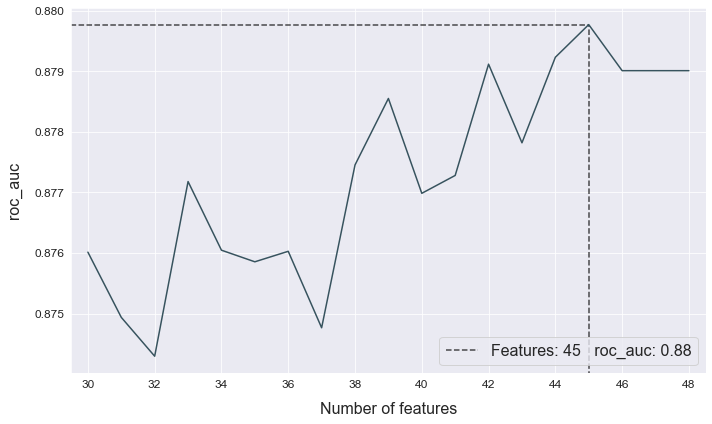

In [11]:
# After applying RFECV, we can plot the score per number of features
atom.plot_rfecv()

In [12]:
# Let's see how the model performs now
atom.run("LGB_dfs")  # Add a tag to the model's acronym to not overwrite previous one


Training ===================================== >>
Models: LGB_dfs
Metric: roc_auc


Results for LightGBM:         
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.994
Test evaluation --> roc_auc: 0.8774
Time elapsed: 0.511s
-------------------------------------------------
Total time: 0.511s


Final results ========================= >>
Duration: 0.511s
------------------------------------------
LightGBM --> roc_auc: 0.8774


## Genetic Feature Generation

In [13]:
# Create another branch for the genetic features
# Split form master to avoid the dfs features
atom.branch = "gfg_from_master"

New branch 'gfg' successfully created!


In [14]:
# Create new features using Genetic Programming
atom.feature_generation(strategy='GFG', n_features=20, generations=10, population=2000)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.17         0.127544        3         0.504266              N/A     10.16s
   1     3.10          0.33852        5         0.536639              N/A      9.25s
   2     3.50         0.443648        9         0.541754              N/A      8.16s
   3     4.48         0.476799        7         0.544984              N/A      6.89s
   4     6.25          0.51219       13         0.546135              N/A      5.70s
   5     7.45         0.508814        9         0.550855              N/A      4.62s
   6     7.66         0.501224       11          0.55326              N/A      3.49s
   7     8.05         0.498132       11         0.553417              N/A      2.32s
   8     9.52         0.497282       13        

In [15]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features

,name,description,fitness
0,Feature 24,"mul(mul(sub(sub(sub(Humidity3pm, Sunshine), Su...",0.542417
1,Feature 25,"mul(sub(sub(sub(Humidity3pm, Sunshine), Sunshi...",0.542417
2,Feature 26,"mul(Humidity3pm, mul(sub(sub(sub(Humidity3pm, ...",0.542417
3,Feature 27,"mul(sub(sub(Humidity3pm, Sunshine), Sunshine),...",0.542260
4,Feature 28,"mul(mul(sub(Humidity3pm, Sunshine), WindGustSp...",0.542260


In [16]:
# Fit the model again
atom.run("LGB_gfg", metric="auc")


Training ===================================== >>
Models: LGB_gfg
Metric: roc_auc


Results for LightGBM:         
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9894
Test evaluation --> roc_auc: 0.8771
Time elapsed: 0.332s
-------------------------------------------------
Total time: 0.332s


Final results ========================= >>
Duration: 0.332s
------------------------------------------
LightGBM --> roc_auc: 0.8771


## Analyze results

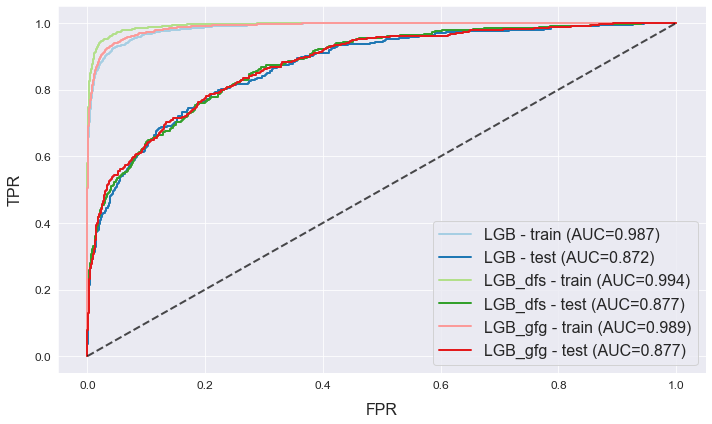

In [17]:
# Use atom's plots to compare the three models
atom.palette = "Paired"
atom.plot_roc(dataset="both")
atom.reset_aesthetics()

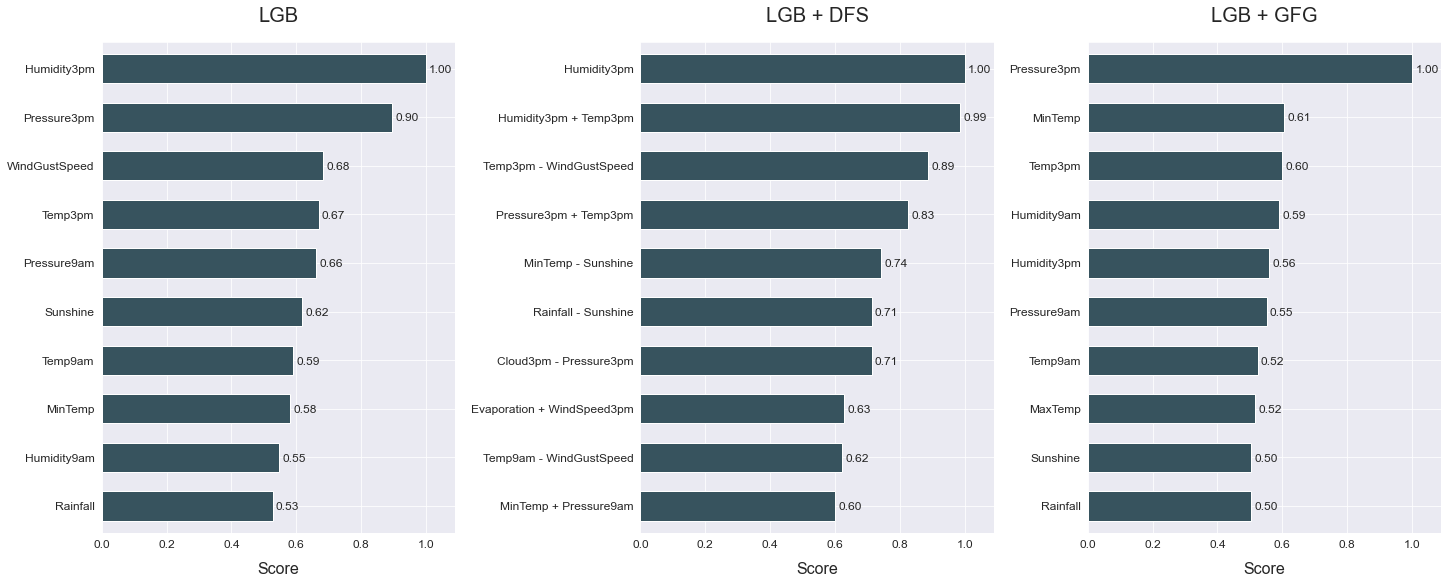

In [18]:
# For busy plots it might be useful to use a canvas
with atom.canvas(1, 3, figsize=(20, 8)):
    atom.lgb.plot_feature_importance(show=10, title="LGB")
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + DFS")
    atom.lgb_gfg.plot_feature_importance(show=10, title="LGB + GFG")

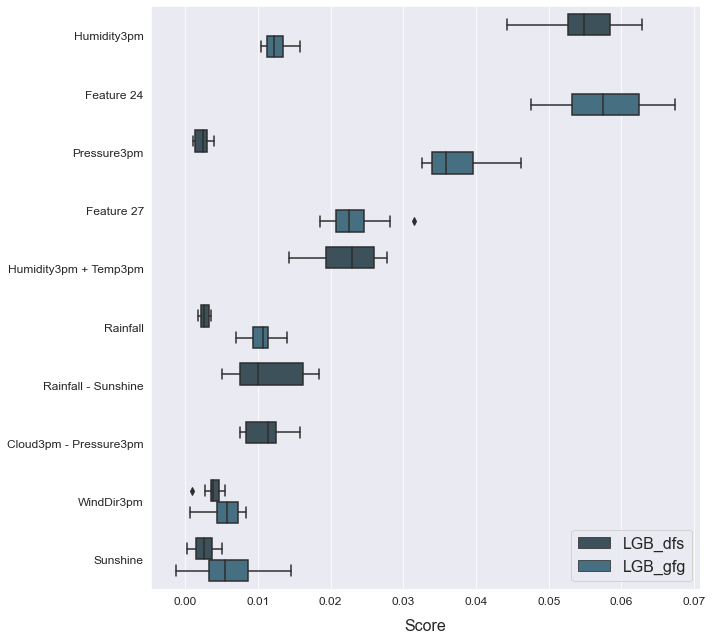

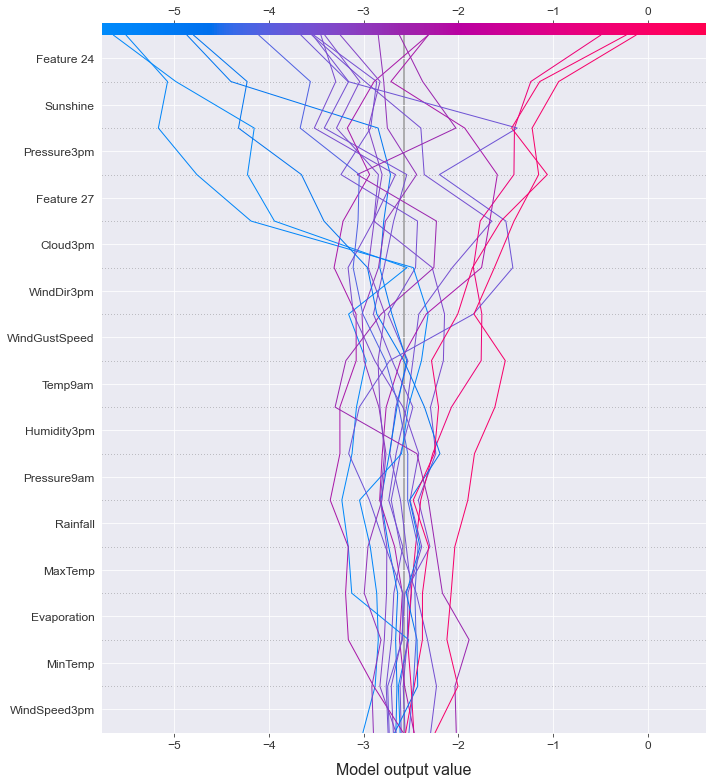

In [19]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(models=["LGB_DFS", "LGB_GFG"], show=10)
atom.LGB_gfg.decision_plot(index=(-20, -1), show=15)